# XOR with Neural Network

Welcome! My name is Yasin Pourraisi.  
In this work, I focus on solving the XOR problem using a neural network. This not only illustrates the capability of modern neural architectures but also serves as a gateway to understanding how deep learning can address problems involving nonlinear separability.

***XOR :***

The XOR problem is a classic issue in machine learning and neural networks that demonstrates the limitations of simple models like a single-layer perceptron.
XOR stands for "exclusive OR", a logical operation on two binary inputs.

| Input A | Input B | A XOR B |
| ------- | ------- | ------- |
| 0       | 0       | 0       |
| 0       | 1       | 1       |
| 1       | 0       | 1       |
| 1       | 1       | 0       |

***Why it’s a problem:***

If you plot the inputs (A, B) on a 2D plane and color points by output:

- (0,0) → 0
- (1,1) → 0
- (0,1) → 1
- (1,0) → 1

You’ll see that the classes are not linearly separable.
In other words, you can’t draw a single straight line to separate the 1’s from the 0’s.
A single-layer perceptron (linear classifier) fails here.
so we have to use a Neural Network.

***Why it’s important:***

In 1969, Minsky & Papert showed that perceptrons couldn’t solve XOR, which slowed down neural network research (AI “winter”).
Later, multi-layer perceptrons (MLPs) with hidden layers and nonlinear activation functions solved it.
XOR became the canonical example proving that deep learning models can represent nonlinear decision boundaries.



**Contact me:**  
- GitHub: [yasinpurraisi](https://github.com/yasinpurraisi)  
- Email: yasinpourraisi@gmail.com  
- Telegram: @yasinprsy


### Import Required Libraries

Let's start by importing all the necessary libraries for data processing, visualization, and building our model.

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

### Create data set
Coordinates x → Class y
- (0,0) → 0
- (1,1) → 0
- (0,1) → 1
- (1,0) → 1

In [30]:

class XOR_Data(Dataset):
    
    def __init__(self, data_size=100):
        # 100 by 2 array for the X values representing the coordinates
        self.x = torch.zeros((data_size, 2))
        # 100 by 1 array for the class the X value belongs to
        self.y = torch.zeros((data_size, 1))
        # Split the dataset into 4 parts
        for i in range(data_size // 4):
            # x = (0,0) of class y = 0
            self.x[i, :] = torch.Tensor([0.0, 0.0]) 
            self.y[i, 0] = torch.Tensor([0.0])

            # x = (0,1) of class y = 1
            self.x[i + data_size // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + data_size // 4, 0] = torch.Tensor([1.0])
    
            # x = (1,0) of class y = 1
            self.x[i + data_size // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + data_size // 2, 0] = torch.Tensor([1.0])
    
            # x = (1,1) of class y = 0
            self.x[i + 3 * data_size // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * data_size // 4, 0] = torch.Tensor([0.0])

            # Add some noise to the X values to make them different
            self.x = self.x + 0.01 * torch.randn((data_size, 2))
        self.len = data_size

    # Getter
    def __getitem__(self, index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_stuff(self):
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")
        plt.legend()

Use the following function to plot the data: 


In [31]:

def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

### Make some data

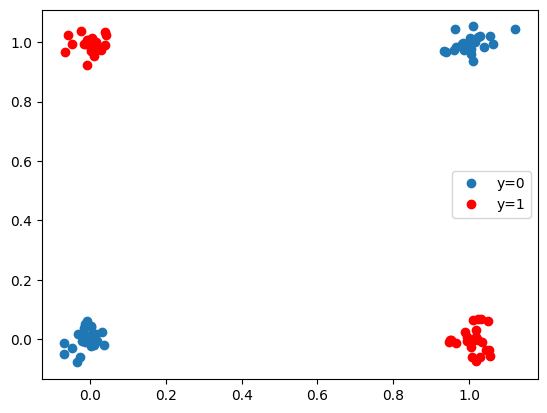

In [32]:
data_set = XOR_Data()
data_set.plot_stuff()

### Neural Network Module
I define the neural network with one hidden layer :
- ***Input layer*** <code>D_in</code>: takes two binary inputs (0 or 1).
- ***Hidden layer*** <code>H</code>: applies a linear transformation followed by a sigmoid activation to capture the nonlinearity of the XOR function.
- ***Output layer*** <code>D_out</code>: applies another linear transformation and sigmoid activation to produce an output between 0 and 1, representing the predicted XOR value.

Mathematically, the model can be expressed as:
- $h=σ(W1​x+b1​) $
- $y^​=σ(W2​h+b2​)$

In [33]:
class Net(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
 
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x)) 
        x = torch.sigmoid(self.linear2(x))
        return x

Use the following function to calculate accuracy: 


In [34]:

def accuracy(model, data_set):
    # Rounds prediction to nearest integer 0 or 1
    # Checks if prediction matches the actual values and returns accuracy rate
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

### Define a function to train model


In [35]:

def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    # Lists to keep track of cost and accuracy
    COST = []
    ACC = []

    for epoch in range(epochs):
        
        total_loss=0

        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            yhat = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(yhat, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            total_loss+=loss.item()
        # Saves cost and accuracy
        ACC.append(accuracy(model, data_set))
        COST.append(total_loss)
        
    # Prints Cost vs Epoch graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    # Prints Accuracy vs Epoch graph
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

    return COST

### Creating the model
i create the model with different neuron size in the hidden layer and plot the results

- ### One Neuron

Not enough to solve XOR.

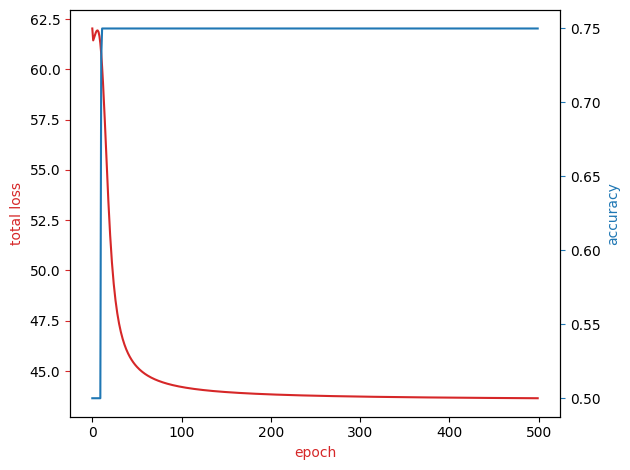

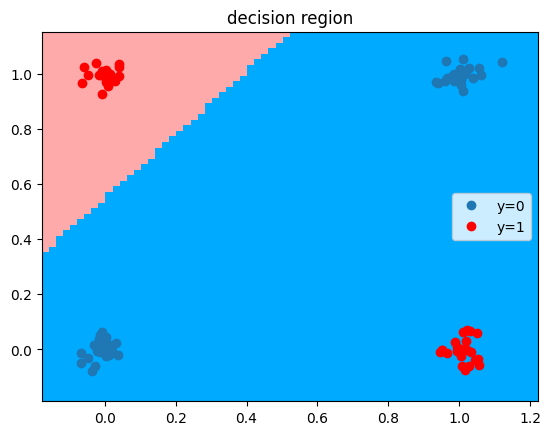

In [36]:
model = Net(2, 1, 1)

learning_rate = 0.1
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Create a Data Loader for the training data with a batch size of 1 
train_loader = DataLoader(dataset=data_set, batch_size=1)
# Using the training function train the model on 500 epochs
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
# Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

- ### Two Neurons
enough to solve XOR.

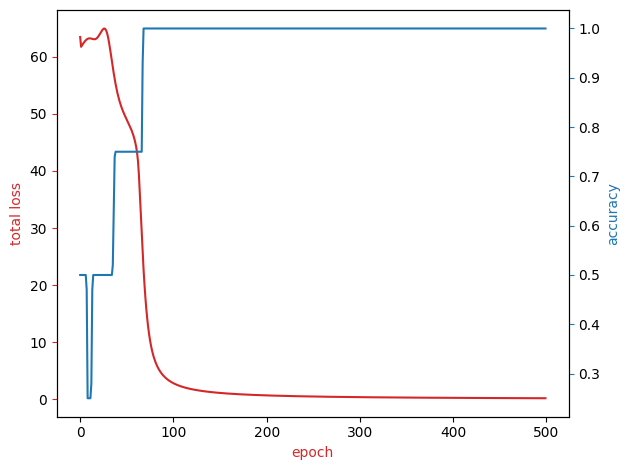

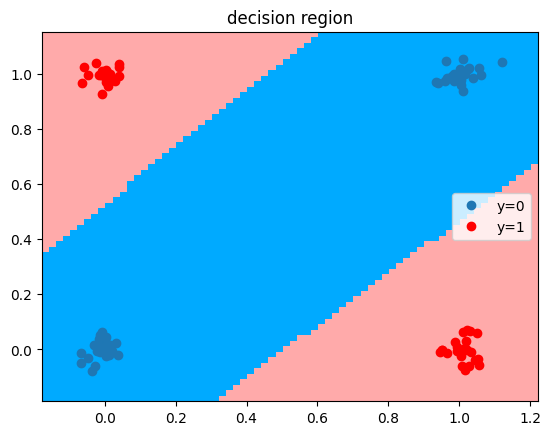

In [37]:
model = Net(2, 2, 1)

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
plot_decision_regions_2class(model, data_set)

- ### Three Neurons
enough to solve XOR, sometimes faster or more robust.

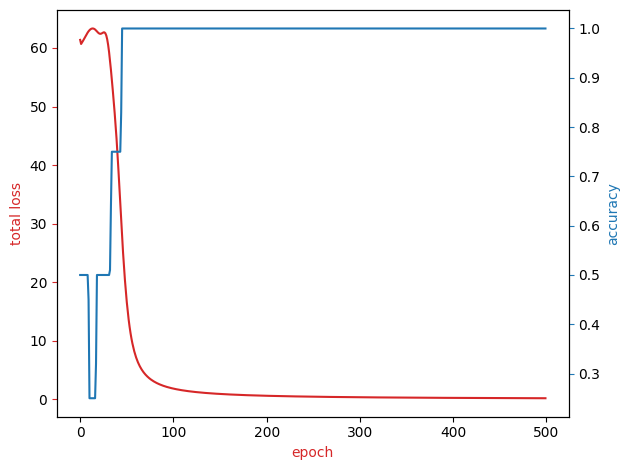

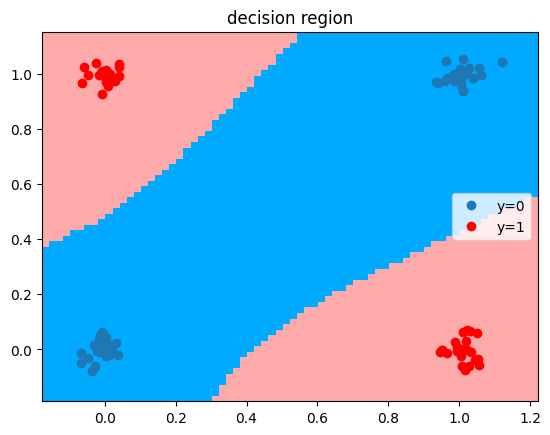

In [38]:
model = Net(2, 3, 1)

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
plot_decision_regions_2class(model, data_set)

---

## Conclusion

In this notebook, i implemented a simple **neural network with one hidden layer** to solve the classic **XOR problem**.  
This example shows how even a small feedforward network with nonlinear activation functions can learn decision boundaries that are not linearly separable.  

Thanks for following along! 
